**RL: задача о многоруком бандите**

**Замечание**

Графики из презентации у нас были нарисованы в другом ноутбуке, который выглядит ужасно. Также графики рисуются довольно долго. Мы защищали этот проект в МФТИ, поэтому граифик реальные. Функция, при помощи которой мы их рисовали, находится в самом низу ноутбука в отдельной ячейке

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm

In [2]:
def get_regret(true_means, actions):
    max_mean = np.max(true_means)
    r = [max_mean - true_means[a] for a in actions]
    return np.cumsum(r)

# Datasets for online-classification

Ирисы

<Figure size 1000x600 with 0 Axes>

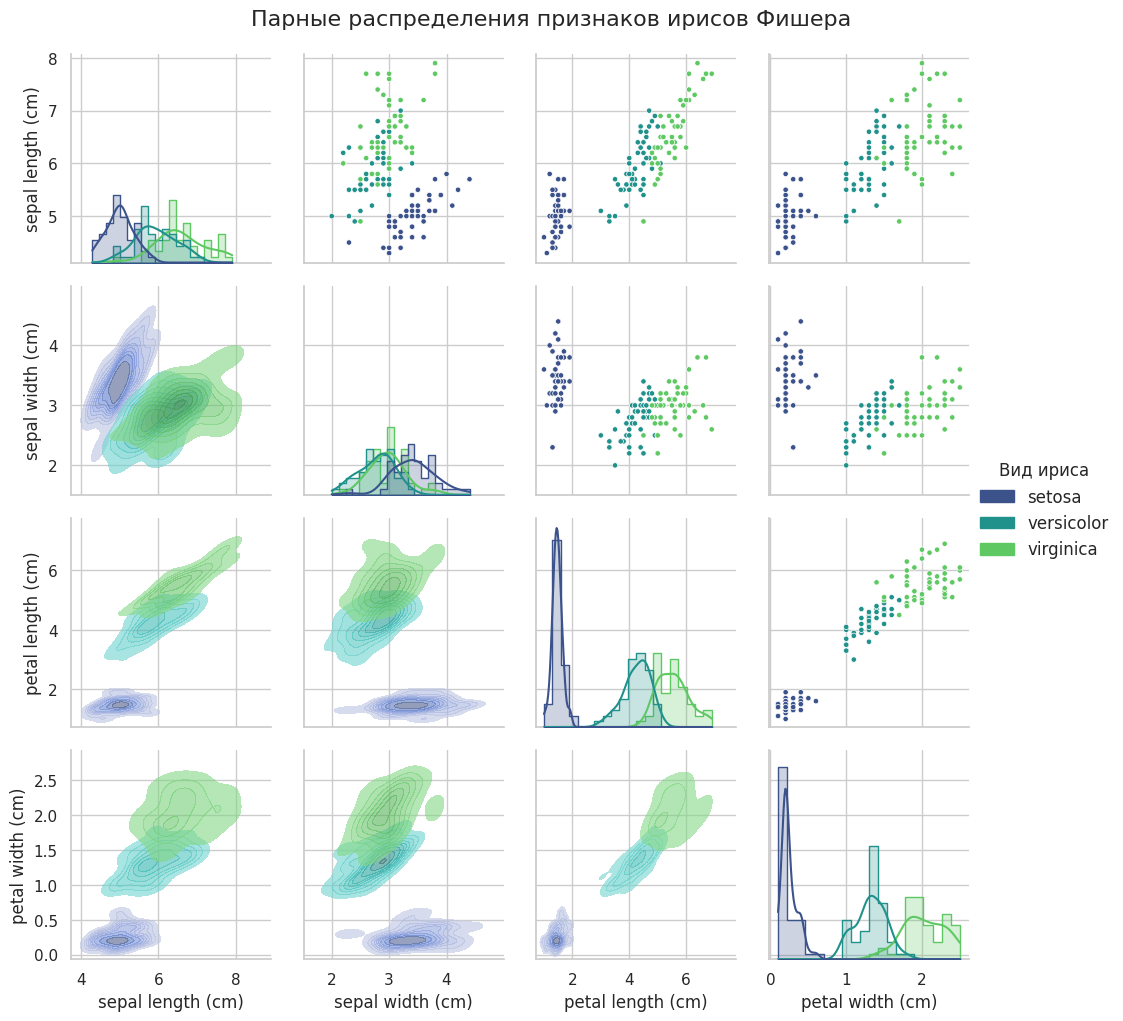

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
data, target = load_iris(return_X_y=True)

iris_df = pd.DataFrame(data, columns=iris.feature_names)
iris_df['species'] = target
iris_df['species'] = iris_df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

sns.set(style="whitegrid", palette="muted", rc={"figure.figsize":(12, 8)})
plt.figure(figsize=(10, 6))

g = sns.PairGrid(iris_df, hue="species", palette="viridis")
g.map_upper(sns.scatterplot, s=15, edgecolor="white", linewidth=0.5)
g.map_lower(sns.kdeplot, fill=True, alpha=0.6)
g.map_diag(sns.histplot, kde=True, bins=20, element="step")
g.add_legend(title="Вид ириса", fontsize=12)
plt.suptitle("Парные распределения признаков ирисов Фишера", y=1.02, fontsize=16)

plt.show()

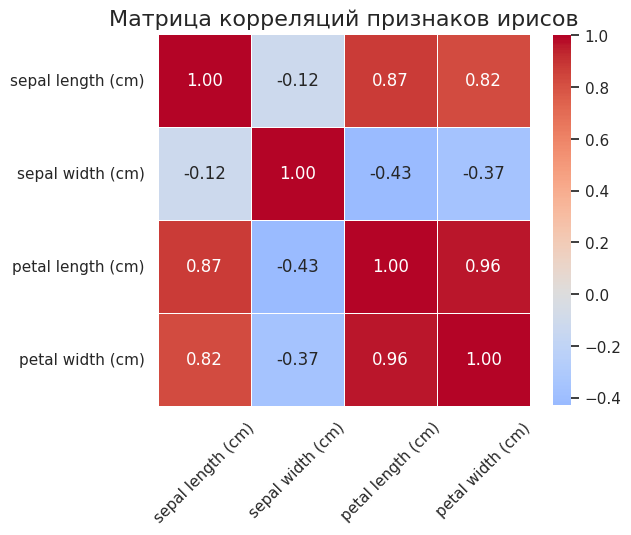

In [25]:
plt.figure(figsize=(6, 6))
corr = iris_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0,
           linewidths=.5, square=True,
           fmt=".2f", cbar_kws={"shrink": .8})
plt.title("Матрица корреляций признаков ирисов", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Грибы

In [32]:
!pip install ucimlrepo

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)
X = mushroom.data.features
y = mushroom.data.targets
y = (y == 'p').astype(int)
y.columns = ['poisonous']
X = pd.get_dummies(X, drop_first=True)

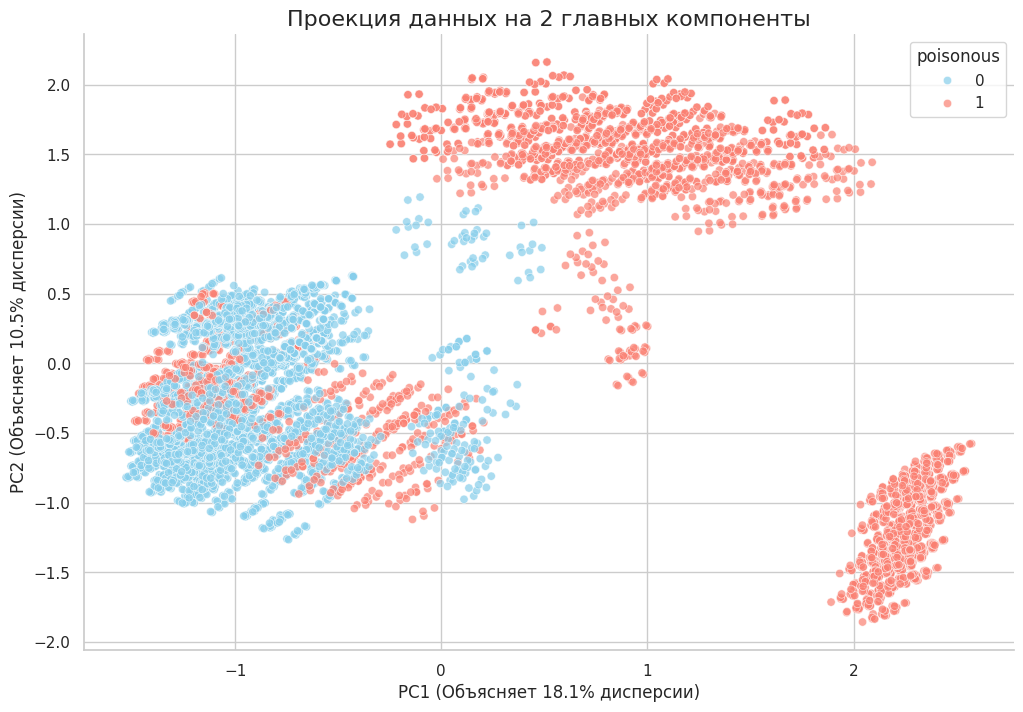

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y['poisonous'],
               palette=['skyblue','salmon'], alpha=0.7)
plt.title('Проекция данных на 2 главных компоненты', fontsize=16)
plt.xlabel('PC1 (Объясняет {:.1f}% дисперсии)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (Объясняет {:.1f}% дисперсии)'.format(pca.explained_variance_ratio_[1]*100))
sns.despine()

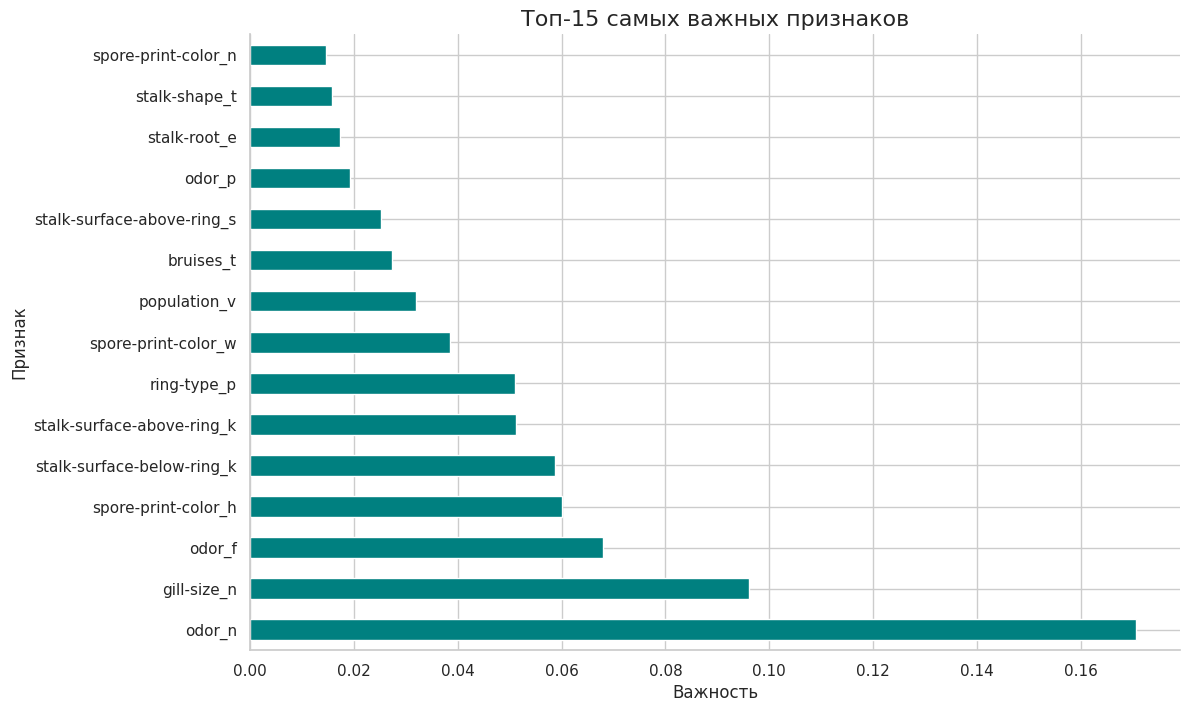

In [38]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y.values.ravel())
importances = pd.Series(model.feature_importances_, index=X.columns)

plt.figure(figsize=(12, 8))
importances.nlargest(15).plot(kind='barh', color='teal')
plt.title('Топ-15 самых важных признаков', fontsize=16)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признак', fontsize=12)
sns.despine()

In [43]:
y['poisonous'].value_counts()

,count
poisonous,
0,4208
1,3916


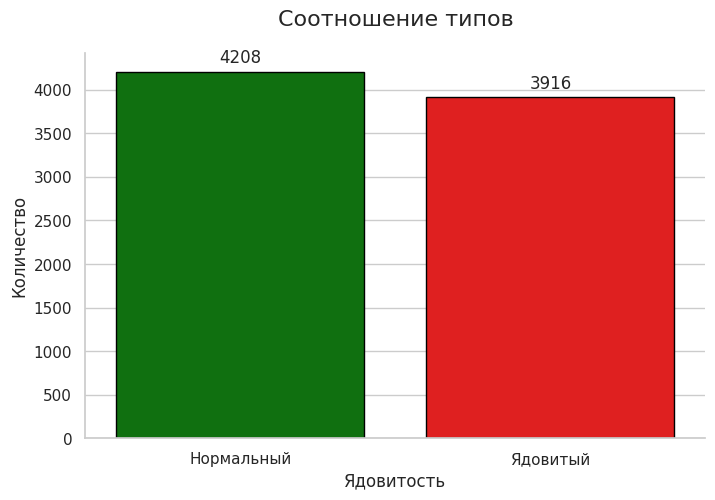

In [53]:
pois_counts = y['poisonous'].value_counts()

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=pois_counts.index,
    y=pois_counts.values,
    hue=pois_counts.index,
    palette=["green", "red"],
    edgecolor="black",
    linewidth=1,
    legend=False
)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.0f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=12,
    )

plt.title("Соотношение типов", fontsize=16, pad=20)
plt.xlabel("Ядовитость")
plt.ylabel("Количество")
plt.xticks(ticks=[0, 1], labels=["Нормальный", "Ядовитый"])
sns.despine()
plt.show()

# Non-context

ϵ - greedy

Init estims = [4.08043315 0.31594848 4.13640101 1.7234474 ]
means = [0.59766255 0.86327744 0.91982354 0.44630645]
[1.000e+00 8.638e+03 2.000e+01 2.000e+00]
[2.00e+00 9.97e+03 2.50e+01 3.00e+00]
[0.5        0.8663992  0.8        0.66666667]
[  25. 2180. 6785.   10.]
[  33. 2551. 7392.   24.]
[0.75757576 0.85456684 0.9178842  0.41666667]
[ 161. 1825. 6823.   88.]
[ 273. 2107. 7384.  236.]
[0.58974359 0.86616042 0.92402492 0.37288136]
[ 445.  642. 7049.  320.]
[ 781.  749. 7722.  748.]
[0.56978233 0.85714286 0.91284641 0.42780749]


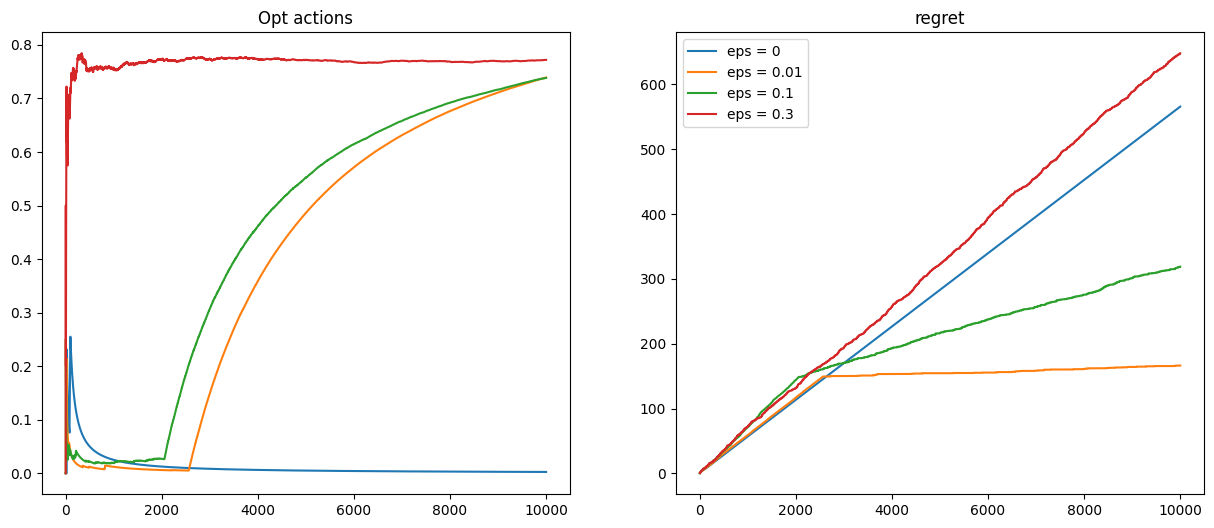

In [6]:
num_iters = 10000
num_hands = 4

learning_rate = 0.01

epss = [0, 0.01, 0.1, 0.3]

estim = np.random.uniform(0, 5, (num_hands))
print(f"Init estims = {estim}")

means = np.random.uniform(0, 1, (num_hands))
print(f"means = {means}")

opts = [[] for _ in range(len(epss))]
regrets = []

for n, eps in enumerate(epss):
    estim = np.random.uniform(0, 5, (num_hands))
    total_rewards = np.zeros((num_hands,))
    total_usage = np.zeros((num_hands,))
    actions = []
    c = 0
    for i in range(1, num_iters + 1):
        p = np.random.uniform(0, 1)
        cur_rewards = np.array([np.random.binomial(1, p) for p in means])
        num_hand = 0
        if p <= eps:
            num_hand = np.random.randint(0, num_hands)
        else:
            num_hand = np.argmax(estim)

        actions.append(num_hand)

        total_usage[num_hand] += 1
        total_rewards[num_hand] += cur_rewards[num_hand]

        if num_hand == np.argmax(means):
            c += 1

        opts[n].append(c / i)

        # estim[num_hand] = estim[num_hand] + learning_rate * (cur_rewards[num_hand] - estim[num_hand])
        estim[num_hand] = estim[num_hand] + 1 / total_usage[num_hand] * (cur_rewards[num_hand] - estim[num_hand])


    regrets.append(get_regret(means, actions))

    print(total_rewards)
    print(total_usage)
    print(estim)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))


for opt, eps, reg in zip(opts, epss, regrets):
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_iters + 1), opt, label = f"eps = {eps}")
    plt.title("Opt actions")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_iters + 1), reg, label = f"eps = {eps}")
    plt.title("regret")

plt.legend(loc = 'best')
plt.show()

UCB

means = [0.17021399 0.0379292  0.50153389 0.86254749 0.52567468 0.64382982
 0.38592995 0.56036322 0.52256395 0.05980488]


  0%|          | 0/10000 [00:00<?, ?it/s]

[   1    1    1 9991    1    1    1    1    1    1]


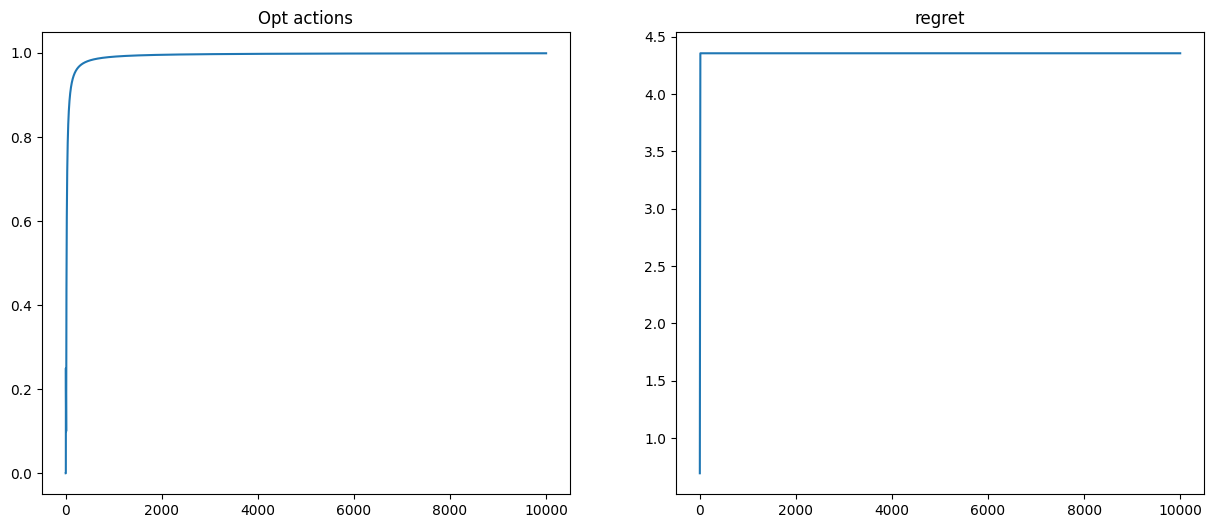

In [7]:
def UCB(estims, c, num_iter, total_used):
    total_used_right = np.where(total_used > 0, total_used, 1e-9)
    ucbs = estims + c * np.sqrt((np.log(num_iter))/(total_used_right))
    return np.argmax(ucbs)

num_iters = 10000
num_hands = 10

estim = np.zeros((num_hands,))

means = np.random.uniform(0, 1, (num_hands))
print(f"means = {means}")

regret = 0

c = 0.1

opt = []
opt_act = 0
actions = []

total_rewards = np.zeros((num_hands,))
total_usage = np.zeros((num_hands,))
for i in tqdm(range(1, num_iters+1)):
    p = np.random.uniform(0, 1)
    cur_rewards = np.array([np.random.binomial(1, p) for p in means])
    num_hand = UCB(estim, c, i, total_usage)
    actions.append(num_hand)

    total_usage[num_hand] += 1
    total_rewards[num_hand] += cur_rewards[num_hand]
    # print(f"num hand = {num_hand}")
    # print("Before", estim)
    estim[num_hand] += (cur_rewards[num_hand] - estim[num_hand])/total_usage[num_hand]
    # print("After", estim)
    if num_hand == np.argmax(means):
        opt_act += 1

    opt.append(opt_act / i)

regret = get_regret(means, actions)

print(total_usage.astype(int))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))


plt.subplot(1, 2, 1)
plt.plot(range(1, num_iters + 1), opt)
plt.title("Opt actions")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_iters + 1), regret)
plt.title("regret")

plt.show()

Softmax

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

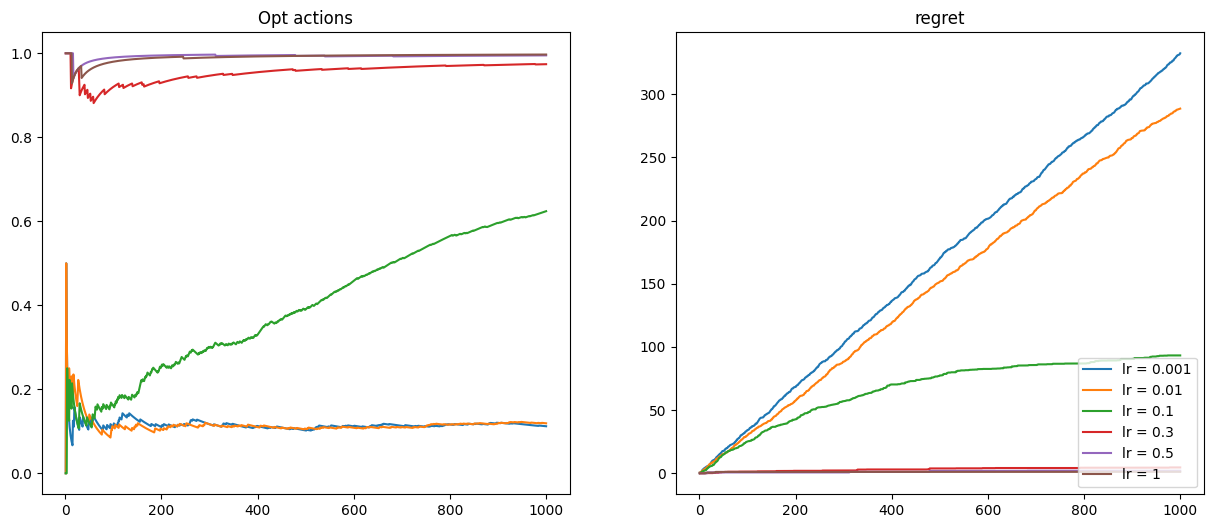

In [3]:
num_iters = 1000
num_hands = 10

learning_rates = [1e-3, 1e-2, 1e-1, 0.3, 0.5, 1]

h = np.zeros((num_hands,))

means = np.random.uniform(0, 1, (num_hands))

total_rewards = np.zeros((num_hands,))
total_usage = np.zeros((num_hands,))

actions = [[] for _ in range(len(learning_rates))]
opt = [[] for _ in range(len(learning_rates))]

regrets = []

means, means.argmax()

for q, learning_rate in enumerate(learning_rates):
  opt_act = 0
  cumm_reward = 0
  for i in tqdm(range(1, num_iters+1)):
      cur_rewards = np.array([np.random.binomial(1, p) for p in means])
      probs = F.softmax(torch.tensor(h), dim = 0).numpy()
      u = np.random.uniform(0, 1)
      num_hand = np.random.choice(num_hands, p=probs)
      h[num_hand] = h[num_hand] + learning_rate * (cur_rewards[num_hand] - cumm_reward / i)*(1 - probs[num_hand])
      for hand in range(num_hands):
        if (hand == num_hand): continue
        h[hand] = h[hand] - learning_rate * (cur_rewards[num_hand] - cumm_reward / i)*probs[hand]
      cumm_reward += cur_rewards[num_hand]
      total_rewards[num_hand] += cur_rewards[num_hand]
      total_usage[num_hand] += 1
      actions[q].append(num_hand)
      if num_hand == np.argmax(means):
        opt_act += 1
      opt[q].append(opt_act / i)
  regrets.append(get_regret(means, actions[q]))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))

for regret, optim, lr in zip(regrets, opt, learning_rates):
  plt.subplot(1, 2, 1)
  plt.plot(range(1, num_iters + 1), optim, label = f"lr = {lr}")
  plt.title("Opt actions")

  plt.subplot(1, 2, 2)
  plt.plot(range(1, num_iters + 1), regret, label = f"lr = {lr}")
  plt.title("regret")

plt.legend(loc='lower right')
plt.show()

Tompson Sampling

[0.01312726 0.82163002 0.31607216 0.50767583 0.35786548 0.85413984
 0.84040498 0.14663554 0.61356435 0.96706966]
[   0   63    0    1    3   32   43    0    1 9518]
[   2   71    2    3    6   37   48    3    3 9825]


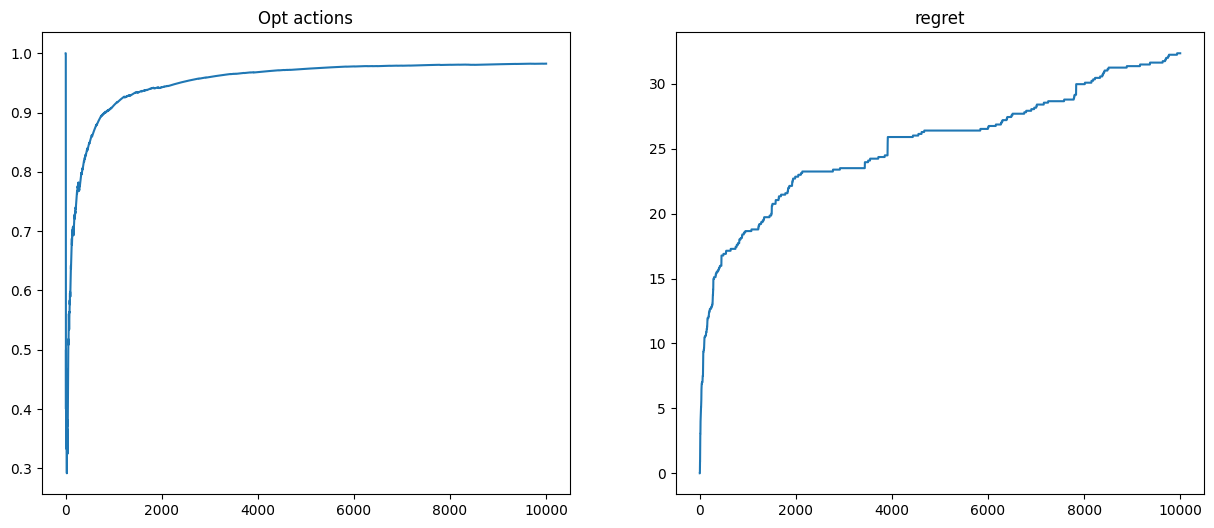

In [9]:
num_iters = 10000
num_hands = 10

means = np.random.uniform(0, 1, (num_hands))
print(means)
alpha = np.ones((num_hands,))
beta = np.ones((num_hands,))

total_usage = np.zeros((num_hands,))
total_rewards = np.zeros((num_hands,))

actions = []

opt = []

opt_act = 0

for i in range(1, num_iters+1):
    prior = np.random.beta(alpha, beta)
    num_hand = np.argmax(prior)
    reward = np.random.binomial(1, means[num_hand])
    alpha[num_hand] += reward
    beta[num_hand] += 1 - reward
    total_rewards[num_hand] += reward
    total_usage[num_hand] += 1
    actions.append(num_hand)

    if num_hand == np.argmax(means):
        opt_act += 1

    opt.append(opt_act / i)

print(total_rewards.astype(int))
print(total_usage.astype(int))

regret = get_regret(means, actions)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))


plt.subplot(1, 2, 1)
plt.plot(range(1, num_iters + 1), opt)
plt.title("Opt actions")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_iters + 1), regret)
plt.title("regret")

plt.show()

# Context

LTS (Basic)

In [10]:
from abc import ABC, abstractmethod
class Bandit(ABC):
    @abstractmethod
    def __init__(self, n_arms: int):
        self.n_arms = n_arms

    @abstractmethod
    def select_arm(self) -> int:
        pass

    @abstractmethod
    def update(self, chosen_arm: int, reward: float):
        pass

In [11]:
class BasicLinTS(Bandit):
  def __init__(self, n_arms, v, context_length, alpha, lr):
    self.n_arms = n_arms
    self.context_length = context_length
    self.B = np.eye(self.context_length * self.n_arms)
    self.mu = np.zeros((self.context_length * self.n_arms,))
    self.f = np.zeros((self.context_length * self.n_arms,))
    self.v = v
    self.contexts = None
    self.actions = []
    self.alpha = alpha
    self.lr = lr
    self.name = "lin"


  def select_arm(self, context) -> int:
    mu_est = np.random.multivariate_normal(
         self.mu,
         self.v ** 2 * np.linalg.inv(self.B)
         )
    self.contexts = self._get_context_for_hands(context, self.alpha)
    num_hand = np.argmax((mu_est @ self.contexts.T))

    self.actions.append(num_hand)
    return num_hand

  def update(self, chosen_arm: int, reward: float):
      self.B += self.lr * np.outer(self.contexts[chosen_arm],  self.contexts[chosen_arm])
      self.f += self.lr * self.contexts[chosen_arm] * reward
      self.mu = np.linalg.inv(self.B) @ self.f

  def _get_context_for_hands(self, context, alpha):
      n_arms = self.n_arms
      context_length = self.context_length
      matrix = np.zeros((n_arms, n_arms * context_length))

      for i in range(n_arms):
          start_index = i * context_length
          end_index = (i + 1) * context_length
          matrix[i, start_index:end_index] = context * alpha
      return matrix

In [27]:
band = BasicLinTS(num_hands, 0.01, data.shape[1], 1.6, 1)
num_bandits = 3

In [29]:
actions = []
num_iters = 2000
regret = []
weights = np.ones((num_bandits,))
for i in range(num_iters):
  i = np.random.choice(iris_df.shape[0])
  context = data[i]
  num_arm = band.select_arm(context)
  reward = int(num_arm == target[i])
  band.update(num_arm, reward)
  regret.append(1 - reward)
  actions.append(num_arm)

Все графики были сделаны через функцию в самом низу

SGD

In [ ]:
class SGDTSBandit:
    def __init__(self, d, K, tau, alpha=5.0, R=1.0, c1=1.0, c3=0.25, T=10000):
        self.d = d
        self.K = K
        self.tau = tau
        self.alpha = alpha
        self.R = R
        self.c1 = c1
        self.c3 = c3
        self.T = T

        self.X_hist = []
        self.Y_hist = []

        self.t = 0
        self.theta_hat = None
        self.C_center = None
        self.C_radius = 2.0
        self.theta = None
        self.tilde_theta = []
        self.theta_ts = None
        self.j = 0

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def __project_to_C(self, theta):

        delta = theta - self.C_center
        norm = np.linalg.norm(delta)

        if norm > self.C_radius:
            return self.C_center + self.C_radius * delta / norm
        else:
            return theta

    def __random_pull(self, X_arms):
        "Случайное действие в exploration-старте"
        return np.random.randint(self.K)

    def __collect_history(self, X, reward):
        "Сохраняем наблюдения"
        self.X_hist.append(X)
        self.Y_hist.append(reward)

    def __count_MSE(self):
        "MLE на первых tau шагах (по всей истории на этом этапе)"
        X_tau = np.array(self.X_hist)
        Y_tau = np.array(self.Y_hist)
        theta = np.zeros(self.d)

        lr = 0.1
        for _ in range(200):
            preds = self.sigmoid(X_tau @ theta)
            grad = -np.dot((Y_tau - preds), X_tau)
            theta -= lr * grad / self.tau
        return theta

    def __init_C_and_theta0(self, theta_hat):
        "Запуск: инициализация выпуклого множества и оценок SGD"
        self.C_center = theta_hat.copy()
        self.theta = theta_hat.copy()
        self.tilde_theta = [theta_hat.copy()]
        self.j = 1   # первое окно

    def __sgd_update(self):
        "Каждые tau раундов: один шаг SGD по последним tau наблюдениям"

        X_tau = np.array(self.X_hist[-self.tau:])
        Y_tau = np.array(self.Y_hist[-self.tau:])
        eta_j = 1 / (self.alpha * self.j)

        grad = np.zeros(self.d)

        for i in range(self.tau):
            grad += (-Y_tau[i] + self.sigmoid(X_tau[i] @ self.theta)) * X_tau[i]

        new_theta = self.theta - eta_j * grad
        self.theta = self.__project_to_C(new_theta)
        self.tilde_theta.append(self.theta.copy())

    def __get_means(self):
        "Вычисляем среднее по SGD-оценкам"
        return np.mean(self.tilde_theta, axis=0)

    def __sample_theta_ts(self):
        "Сэмплируем параметр для Thompson Sampling"
        j = self.j
        g1 = self.R / self.c1 * np.sqrt(self.d * (2 * np.log(1 + 2 * j * self.tau / self.d) + 2 * np.log(self.T))) #! (6)
        g2 = self.tau / self.alpha * np.sqrt(1 + np.log(j)) #! (7)
        A = ((2 * self.c3 * g1 ** 2) / (self.alpha * j) + 2 * g2 ** 2 / j) * np.eye(self.d) #! (5)
        theta_bar = self.__get_means()
        self.theta_ts = np.random.multivariate_normal(theta_bar, A)

    def optimal_arm(self, context):
        X_arms = np.vstack([context, context])

        if self.theta_ts is None:
            return -1

        preds = self.sigmoid(X_arms @ self.theta_ts)
        return np.argmax(preds)

    def select_arm(self, context):
        self.t += 1
        X_arms = np.vstack([context, context])
        # случайно выбираем arm первые tau шагов
        if self.t <= self.tau:
            return self.__random_pull(X_arms)

        # Каждые tau шагов: обновить SGD и Thompson Sampling
        if self.t % self.tau == 1:
            self.j += 1
            self.__sgd_update()

            self.__sample_theta_ts()

        X_arms = np.vstack([context, context])
        preds = self.sigmoid(X_arms @ self.theta_ts)
        return np.argmax(preds)

    def update(self, context, reward):
        regret = 1 - reward
        self.__collect_history(context, regret)

        if self.t == self.tau:
            theta_hat = self.__count_MSE()
            self.theta_hat = theta_hat.copy()
            self.__init_C_and_theta0(theta_hat)
            self.__sample_theta_ts()

графики в презентации (тут их нет)

GTS

In [ ]:
class GTS(Bandit):
  def __init__(self, bandits, n_arms, gamma = 0.3, eta = 0.1, mode = "online"):
    self.bandits = bandits
    self.n_arms = n_arms
    self.gamma = gamma
    self.eta = eta
    self.weights = np.ones((len(bandits))) / len(bandits)
    self.last_cont = None
    self.mode = mode

  def select_arm(self, context) -> int:
      selected_arms = np.array([bandit.select_arm(context) for bandit in self.bandits])
      masks = np.array([(selected_arms == a) for a in range(self.n_arms)]).astype(int)
      probs = np.array([(1 - self.gamma) * np.sum(masks[a]) / np.sum(self.weights) + self.gamma / self.n_arms for a in range(self.n_arms)])
      num_hand = np.random.choice(np.arange(self.n_arms), p = probs / np.sum(probs))
      self.last_cont = context
      return num_hand

  def update(self, chosen_arm: int, context, reward: float):
    mus = np.array([b.mu for b in self.bandits])
    for i in range(len(self.weights)):
      f_i = self.bandits[i].mu @ self.bandits[i]._get_context_for_hands(self.last_cont, 1.6)[chosen_arm]
      self.weights[i] = self.weights[i] * np.exp(-self.eta * np.abs(f_i - reward))
    if self.mode == "online":
      for b in self.bandits:
         b.update(chosen_arm, context, reward)

  def optimal_arm(self, context):
      opt_arms = np.zeros(len(self.bandits))
      for i, band in enumerate(self.bandits):
        opt_arms[i] = band.optimal_arm(context)


# Функция для отрисовки графиков, как в презентации

In [ ]:
def graphs_cont(new_agent, n_arms, n_steps, context, y, p = 100, iters = 10, v =0.1):

    exploration_rate_global = []
    cumulative_reg_p_global = []
    cumulative_regret_global = []
    convergence_global = []

    for _ in tqdm(range(1, iters + 1)):

        agent = new_agent(n_arms, context, v)
        explor_rate = 0
        cum_regret_p = 0
        cum_regret = np.zeros(n_steps)
        explor_rate_history = np.zeros(n_steps)
        regret_history = np.zeros(n_steps)
        convergence_history = np.zeros(n_steps)

        for i in range(p - 1):

            chosen_arm = agent.select_arm(context[i])
            opt_arm = agent.optimal_arm(context[i])

            if chosen_arm != opt_arm:
                explor_rate += 1
                explor_rate_history[i] = 1

            optimal_arm = np.argmax(y[i]) + 1
            if chosen_arm + 1 != optimal_arm:
                cum_regret_p += 1
                regret_history[i] = 1

            cum_regret[i] = cum_regret_p
            convergence_history[i] = (i + 1 - cum_regret_p) / (p - 1)
            reward = y[i][chosen_arm]
            agent.update(chosen_arm, context[i], reward)

        exploration_history_for_p = np.zeros(n_steps + 1)
        regret_history_for_p = np.zeros(n_steps + 1)

        for i, step in enumerate(y[p-1:], start = p-1):
  
            chosen_arm = agent.select_arm(context[i])
            agent_opt_arm = agent.optimal_arm(context[i])

            if chosen_arm != agent_opt_arm:
                explor_rate += 1
                explor_rate_history[i] = 1

            optimal_arm = np.argmax(y[i]) + 1
            cum_regret_p += (chosen_arm + 1 != optimal_arm)
            regret_history[i] = (chosen_arm + 1 != optimal_arm)
            cum_regret[i] = cum_regret[i-1] + (chosen_arm + 1 != optimal_arm)

            convergence_history[i] = (p - cum_regret_p) / p
            reward = step[chosen_arm]
            agent.update(chosen_arm, context[i], reward)

            exploration_history_for_p[i + 1] = explor_rate
            regret_history_for_p[i + 1] = cum_regret_p
            explor_rate -= explor_rate_history[i - p + 1]
            cum_regret_p -= regret_history[i - p + 1]

        exploration_rate_global.append(exploration_history_for_p)
        cumulative_reg_p_global.append(regret_history_for_p)
        cumulative_regret_global.append(cum_regret)
        convergence_global.append(convergence_history)
    fig = plt.figure(figsize=(24, 24))
    gs = GridSpec(2, 2, height_ratios=[1, 1])

    x = np.arange(p, n_steps + 1)
    exploration_rate_global = np.array(exploration_rate_global)

    ax3 = fig.add_subplot(gs[0, 0])
    ax3.plot(x, np.mean(exploration_rate_global, axis = 0)[p:], color = 'blue', label = f'mean of {iters} runs', lw = 3)
    ax3.plot(x, exploration_history_for_p[p:], color = 'grey', alpha = 0.6, label = '1 run')

    ax3.set_ylim(-p / 20, p + p / 20)
    ax3.set_title(f'Exploration rate through past {p} iterations', fontsize = 30, pad = 30)
    ax3.legend(fontsize = 18)
    ax3.grid(True)

    cumulative_reg_p_global = np.array(cumulative_reg_p_global)
    ax4 = fig.add_subplot(gs[0, 1])
    ax4.plot(x, np.mean(cumulative_reg_p_global, axis = 0)[p:], color = 'red', label = f'mean of {iters} runs', lw = 3)
    ax4.plot(x, regret_history_for_p[p:], color = 'grey', alpha = 0.6, label = '1 run')
    ax4.set_ylim(-p / 20, p + p / 20)
    ax4.set_title(f'Num of unoptimal arms through past {p} iterations', fontsize = 30, pad = 30)
    ax4.grid(True)
    ax4.legend(fontsize = 18)

    cumulative_regret_global = np.array(cumulative_regret_global)
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.plot(np.mean(cumulative_regret_global, axis = 0), color = 'red', label = f'mean of {iters} runs', lw = 3.5)
    ax5.plot(cum_regret, color = 'grey', alpha = 0.6, label = '1 run')
    ax5.set_title('Cumulative regret', fontsize = 30, pad = 30)
    ax5.grid(True)
    ax5.legend(fontsize = 18)

    convergence_global = np.array(convergence_global)
    ax6 = fig.add_subplot(gs[1, 1])
    ax6.plot(np.mean(convergence_global, axis = 0), color = 'blue', label = f'mean of {iters} runs', lw = 3.5)
    ax6.plot(convergence_history, color = 'grey', alpha = 0.6, label = '1 run')
    ax6.plot([1] * n_steps, color = 'green', ls = '-', label = 'Best algorithm', lw = 3)
    
    current_ticks = ax6.get_yticks()
    current_labels = [label.get_text() for label in ax6.get_yticklabels()]
    last_values = [conv[-1] for conv in convergence_global]
    mean_last = round(np.mean(last_values), 2)
    new_ticks = np.append(current_ticks, mean_last)
    new_labels = current_labels + [f'{mean_last}']
    ax6.set_yticks(new_ticks)
    ax6.set_yticklabels(new_labels, fontsize=10)
    for label in ax6.get_yticklabels():
        if f'{mean_last}' == label.get_text():
            label.set_color('blue')
            label.set_fontsize(16)
            label.set_fontweight('bold')

    ax6.set_ylim(0, 1.05)
    ax6.set_title('Convergence rate', fontsize = 30, pad = 30)
    ax6.grid(True)    
    ax6.legend(fontsize = 18)
    plt.subplots_adjust(wspace=0.3, hspace = 0.4)
    plt.show()

In [2]:
# Load the notebook
import json
notebook_path = "RL_statprak.ipynb"
with open(notebook_path, "r", encoding="utf-8") as f:
    notebook = json.load(f)

# Remove the problematic widgets metadata
if "metadata" in notebook and "widgets" in notebook["metadata"]:
    del notebook["metadata"]["widgets"]

# Save the notebook
with open(notebook_path, "w", encoding="utf-8") as f:
    json.dump(notebook, f, indent=2)